# Model prototypes
**Author:** Scott Campit

## Summary
This code is aimed to perform image segmentation.

## 1. Import libraries

In [147]:
# Base libraries
import sys

import numpy as np
import json
import itertools
import random
import os
import random

# Deep learning libraries
import keras
from keras import layers
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

# Computer vision libraries
import cv2
import PIL.Image as Image
from skimage import io
import supervisely_lib as sly

# Data visualization libraries
from pylab import rcParams
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 2. Read in the data
The Supervise.ly data has been preprocessed in the `make_tf_data.ipynb` notebook so that it is Tensorflow compatible.

In [148]:
# Path to data
IMAGE_SHAPE = (224, 224, 3)
trainpath = "D:/Data/InterOp/TF/train_04092021"
testpath = "D:/Data/InterOp/TF/test_04092021"

train = tf.data.experimental.load(path=trainpath, 
                                  element_spec={'image': tf.TensorSpec(shape=IMAGE_SHAPE, 
                                                                       dtype=tf.float32, 
                                                                       name=None),
                                                'segmentation_mask': tf.TensorSpec(shape=IMAGE_SHAPE,
                                                                                   dtype=tf.uint8, 
                                                                                   name=None)})
test = tf.data.experimental.load(path=testpath, 
                                 element_spec={'image': tf.TensorSpec(shape=IMAGE_SHAPE, 
                                                                      dtype=tf.float32, 
                                                                      name=None),
                                              'segmentation_mask': tf.TensorSpec(shape=IMAGE_SHAPE,
                                                                                 dtype=tf.uint8, 
                                                                                 name=None)})

## 3. Perform data preprocessing

This code performs some simple augmentations, such as flipping an image.

In [149]:
@tf.function
def data_augmentation(data):
    """
    """
    img_arr = data['image']
    mask_arr = data['segmentation_mask']
    if tf.random.uniform(()) > 0.5:
        img_arr = tf.image.flip_left_right(img_arr)
        mask_arr = tf.image.flip_left_right(mask_arr)

    return img_arr, mask_arr

The dataset is already split into train and test, so we'll initiate some hyperparameters.

In [150]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Let's perform the data augmentation on the training set.

In [151]:
train = train.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

## 4. Visualize an image
We'll create a function that will let us visualize the data.

In [152]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
plt.show()

Now let's look at an image example.

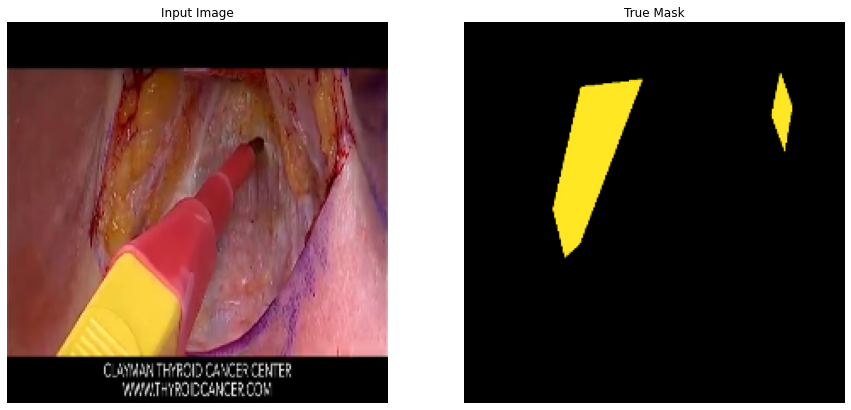

In [153]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## 5. Define the model
Now we'll define the model architecture.

#### Determine the number of output classes
First, we'll set the number of labels that are possible.

In [154]:
meta = "D:/Data/InterOp/Sling Health/meta.json"
f = open(meta)
data = json.load(f)
f.close()

# Grab unique classes in the meta data
ids = []
for i in range(len(data['classes'])):
    ids.append(data['classes'][i]['title'])
print(len(ids))

12


In [166]:
# Number of unique classes from the classification task
OUTPUT_CHANNELS = 3#len(ids)

We'll use the MobileNet model for image segmentation.

In [167]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

We'll grab the decoder.

In [168]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Now let's set the UNET model.

In [169]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=IMAGE_SHAPE)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, 
      kernel_size=3, 
      strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# 3. Train the model
Now let's train the model

In [170]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Let's see what the models predict before training

WARN:tensorflow:5 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000214254FC700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


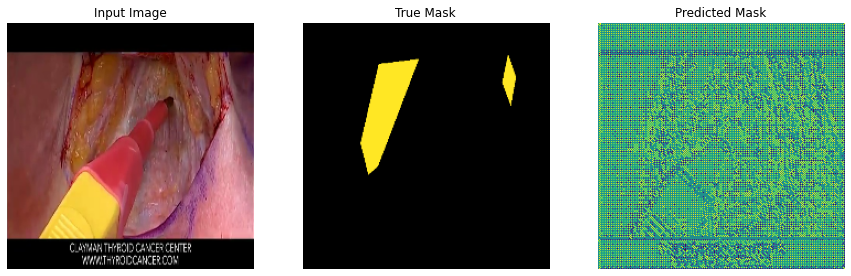

In [171]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                    create_mask(model.predict(sample_image[tf.newaxis, ...]))])
# Show the predictions                    
show_predictions()

Now let's create a callback that let's us see how the model does while training.

In [172]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Finally, let's fit the model.

In [174]:
EPOCHS = 20
VAL_SUBSPLITS=5
VALIDATION_STEPS = len(test)//BATCH_SIZE//VAL_SUBSPLITS
#train = train.batch(BATCH_SIZE)
model_history = model.fit(train, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 3.1485 - accuracy: 0.7430

ValueError: in user code:

    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:1183 test_step
        y_pred = self(x, training=False)
    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:187 assert_input_compatibility
        raise ValueError('Missing data for input "%s". '

    ValueError: Missing data for input "input_15". You passed a data dictionary with keys ['image', 'segmentation_mask']. Expected the following keys: ['input_15']


Okay, let's evaluate the model

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

And now let's visualize the cost curve.

In [ ]:
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Make predictions 

In [ ]:
show_predictions(test_dataset, 3)

Add a batch dimension and pass the image to the model.

In [220]:
result = classifier.predict(img[np.newaxis, ...])

## Now let's set up some functions that will facilitate loading the image.

### `LoadAnnotation` loads the boundary regions

# Batch Iterator

In [ ]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

# Create Tensorflow Neural Network
This bit of code will use the TensorFlow API to tra

## Evaluation metric
First let's create the mean-squared error metric